# YASA

This notebook demonstrates how to use YASA to perform **multi-channels slow-waves detection** from a NumPy array (example 1) or a MNE Raw object (example 2).

Please make sure to install YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

**Important**
- The data must be a numpy array of shape *(n_channels, n_samples)*.
- The sampling frequency `sf` must be the same for all channels.
- A list of the channel names (`ch_names`) must be provided as well.
- The unit of the data must be $\mu V$. Note that the default unit in [MNE](https://martinos.org/mne/dev/generated/mne.io.Raw.html) is $V$. Therefore, if you use MNE, you must multiply your data by 1e6 (1 $V$ = 1,000,000 $\mu V$).

## Example 1: Using NumPy

To illustrate the multi-channel slow-waves detection, we load a full-night 3-channels dataset (Cz, Fz, Pz) sampled at 100 Hz. The data is in compressed NumPy format (*.npz*).

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

# Load data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, chan = f['data'], f['chan']
hypno = np.load('data_full_6hrs_100Hz_hypno.npz').get('hypno')
sf = 100.
times = np.arange(data.size) / sf

print(data.shape, chan)
print(np.round(data[:, 0:5], 3))

(3, 2161058) ['Cz' 'Fz' 'Pz']
[[15.797 22.307 39.922 25.657 27.094]
 [16.896 26.385 40.966 21.833 24.456]
 [ 5.899 14.297 36.592 26.094 23.395]]


*************

**Applying the detection**

To apply the multi-channel detection, we use the [sw_detect_multi](https://raphaelvallat.com/yasa/build/html/generated/yasa.spindles_detect_multi.html#yasa.spindles_detect_multi) function. Note that we pass the hypnogram and restrain the detection to N3 sleep only.

In [2]:
sw = yasa.sw_detect_multi(data, sf, ch_names=chan, hypno=hypno, include=(3))
print(sw.shape[0], 'slow-waves detected.')
sw.head().round(3)

6658 slow-waves detected.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,1868.43,1868.66,1868.86,1869.09,1869.59,1.16,-104.855,99.642,204.497,1022.486,0.862,3,Cz,0
1,1869.59,1869.84,1870.09,1870.26,1870.46,0.87,-81.599,33.650,115.249,460.997,1.149,3,Cz,0
2,1894.97,1895.20,1895.46,1895.63,1896.03,1.06,-80.394,21.457,101.852,391.737,0.943,3,Cz,0
3,1896.03,1896.23,1896.40,1896.51,1896.60,0.57,-69.743,33.369,103.112,606.541,1.754,3,Cz,0
4,1896.60,1896.80,1896.99,1897.08,1897.16,0.56,-109.203,32.762,141.965,747.185,1.786,3,Cz,0


In [3]:
# We print the number of slow-waves detected per channel, as well as the mean slow-waves properties per channel.
display(sw['Channel'].value_counts())
display(sw.groupby('Channel').mean().round(2))

Cz    2255
Pz    2220
Fz    2183
Name: Channel, dtype: int64

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,IdxChannel
Channel,,,,,,,,,,,,
Cz,8505.96,8506.25,8506.53,8506.78,8507.07,1.11,-82.27,65.19,147.47,617.48,0.97,0
Fz,8170.51,8170.80,8171.06,8171.31,8171.61,1.11,-79.89,60.55,140.45,608.30,0.98,1
Pz,8422.55,8422.85,8423.14,8423.39,8423.69,1.14,-81.98,64.98,146.96,595.87,0.96,2


In [4]:
# For plotting purposes, we can easily extract a boolean vector that has the same size as the data
bool_vector = yasa.get_bool_vector(data, sf, sw)
print(bool_vector.sum(1))
print(bool_vector)

[252060 243127 253361]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Plot an average template of the detected slow-waves**

In [5]:
# Get synchronized timing
df_sync_sw = yasa.get_sync_events(data, sf, detection=sw, center='NegPeak', 
                                  time_before=0.4, time_after=0.8)
df_sync_sw.head()

,Time,Event,Amplitude,Channel,IdxChannel
0,-0.40,0,61.463108,Cz,0
1,-0.39,0,56.580524,Cz,0
2,-0.38,0,45.857990,Cz,0
3,-0.37,0,32.071873,Cz,0
4,-0.36,0,23.455547,Cz,0


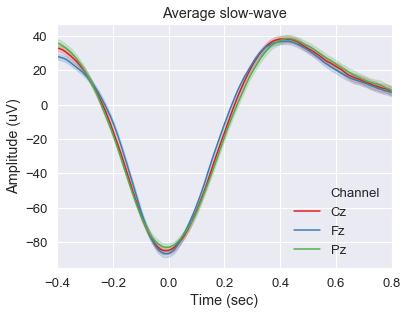

In [6]:
# Plot the average slow-wave
plt.figure(figsize=(6, 4.5))
pal = sns.color_palette("Set1", df_sync_sw['Channel'].nunique())
sns.lineplot(data=df_sync_sw, x='Time', y='Amplitude', hue='Channel', 
            palette=pal)

plt.xlim(df_sync_sw['Time'].min(), df_sync_sw['Time'].max())
plt.title('Average slow-wave')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (uV)')
plt.legend(frameon=False, loc='lower right');

*************

## Example 2: Using a Raw object from MNE-Python

This example demonstrates how to manipulate [MNE Raw object](https://mne-tools.github.io/stable/generated/mne.io.Raw.html#mne.io.Raw). The MNE package has several [functions](https://mne-tools.github.io/stable/python_reference.html#module-mne.io) to load the most standard EEG file formats (EDF, BrainVision, EEGLab, FieldTrip...).

### Load using MNE
For the sake of this example, we'll load a PSG file encoded in the native MNE format (*.fif) using the [mne.io.read_raw_fif](https://martinos.org/mne/stable/generated/mne.io.read_raw_fif.html) function.

In [7]:
import mne

# Load the raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True)

Opening raw data file sub-02_mne_raw.fif...
    Range : 0 ... 293999 =      0.000 ...  2939.990 secs
Ready.
Reading 0 ... 293999  =      0.000 ...  2939.990 secs...


In [8]:
# Let's have a look at the data
print('Chan =', raw.ch_names)
print('Sampling frequency =', raw.info['sfreq'])
print('Data shape =', raw._data.shape)

Chan = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
Sampling frequency = 100.0
Data shape = (9, 294000)


### Applying YASA

In [9]:
# Keep only the channels of interests
raw_eeg = raw.copy().pick_types(eeg=True).drop_channels(['O1', 'O2'])
print('Chan =', raw_eeg.ch_names)

Chan = ['F3', 'F4', 'C3', 'C4']


In [10]:
# Multi-channel slow-waves detection
# Note that since we're using a MNE Raw object, there is no need
# to manually specify the sampling frequency and channel names.
sw = yasa.sw_detect_multi(raw_eeg)
print(sw.shape[0], 'slow-waves detected.')
sw.head().round(3)

296 slow-waves detected.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,0.43,0.64,0.83,0.98,1.14,0.71,-58.425,35.605,94.030,494.895,1.408,F3,0
1,13.84,14.06,14.29,14.53,14.79,0.95,-40.706,39.630,80.336,349.288,1.053,F3,0
2,15.23,15.85,16.02,16.22,16.49,1.26,-95.548,116.929,212.478,1249.868,0.794,F3,0
3,38.04,38.23,38.38,38.51,38.62,0.58,-48.818,44.427,93.245,621.633,1.724,F3,0
4,38.62,38.81,38.96,39.14,39.34,0.72,-108.542,116.249,224.791,1498.608,1.389,F3,0


In [11]:
bool_vector = yasa.get_bool_vector(raw_eeg, detection=sw)
print(bool_vector.sum(1))
print(bool_vector)

[11395  9375  5825  5813]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
